<a href="https://colab.research.google.com/github/saad697/Dynamic-Demand-Forecasting-using-AI/blob/main/Dynamic_Demand_Forecasting_using_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


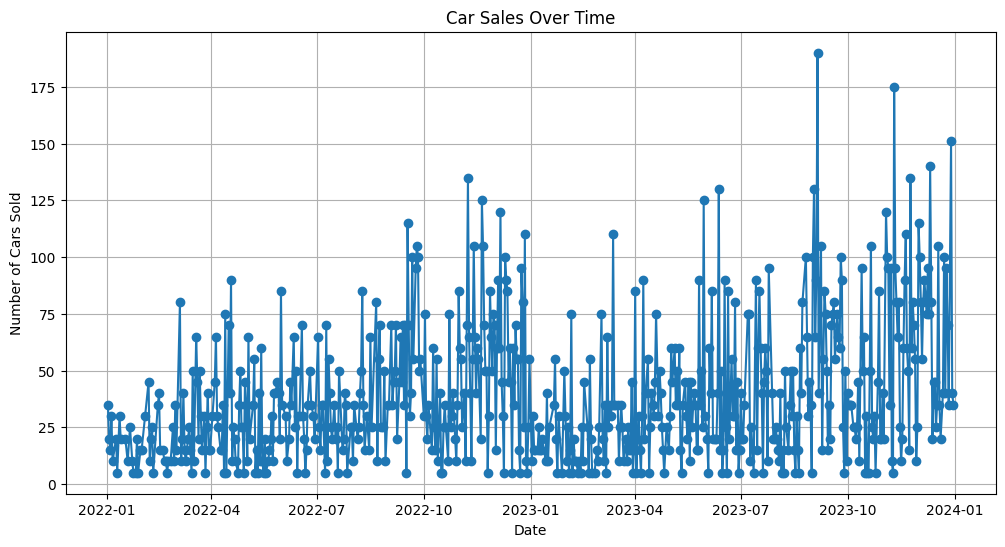

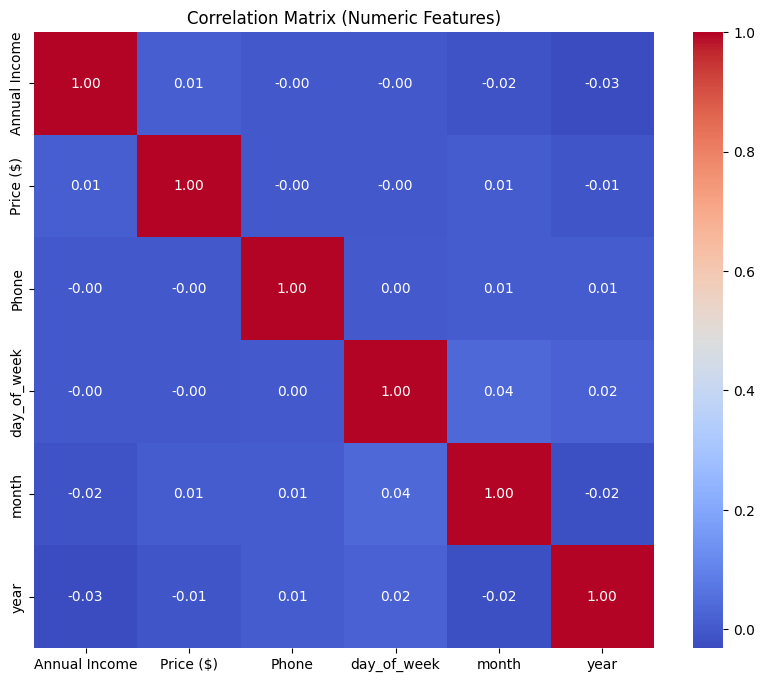

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_2b0a7oj/2s2ticmg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_2b0a7oj/3sp7bdlt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15160', 'data', 'file=/tmp/tmp_2b0a7oj/2s2ticmg.json', 'init=/tmp/tmp_2b0a7oj/3sp7bdlt.json', 'output', 'file=/tmp/tmp_2b0a7oj/prophet_modelwcsxb013/prophet_model-20241117172905.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


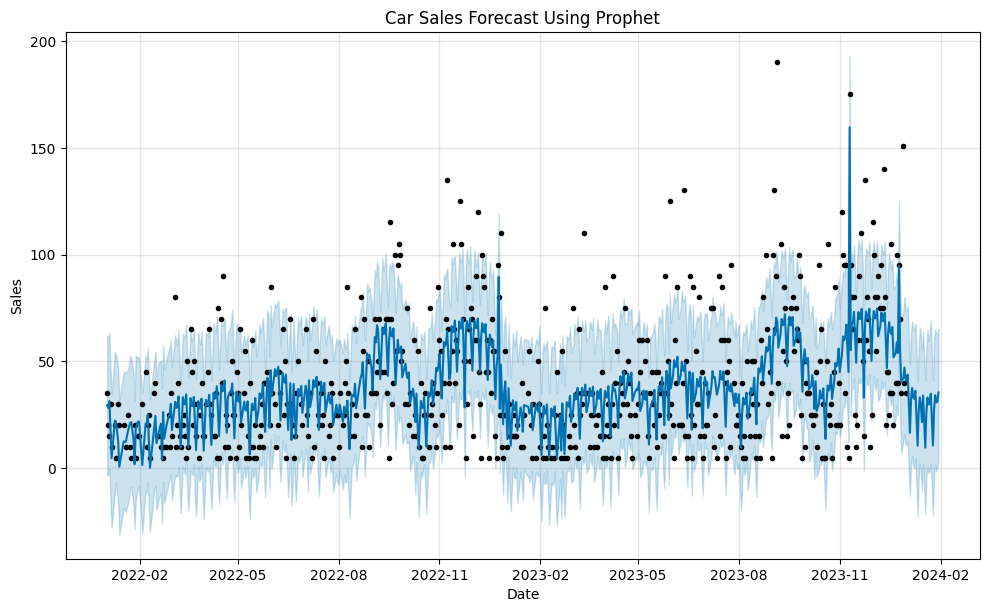

Evaluation Metrics for Prophet:
RMSE: 24.615042418055996
MAE: 18.743206760848178
MAPE: 103.30%
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0367 - val_loss: 0.0450 - learning_rate: 0.0010
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0168 - val_loss: 0.0416 - learning_rate: 0.0010
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0201 - val_loss: 0.0406 - learning_rate: 0.0010
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0190 - val_loss: 0.0431 - learning_rate: 0.0010
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0182 - val_loss: 0.0413 - learning_rate: 0.0010
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0185 - val_loss: 0.0429 - learning_rate: 0.0010
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0189 - val_loss: 0.0399 - learning_rate: 0.0010
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0221 - val_loss: 0.0396 - learning_rate: 0.0010
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0194 - val_loss: 0.0440 - learning_rate: 0.0010
Epoch 10/50
32/32 ━━━━━━━━━━━━

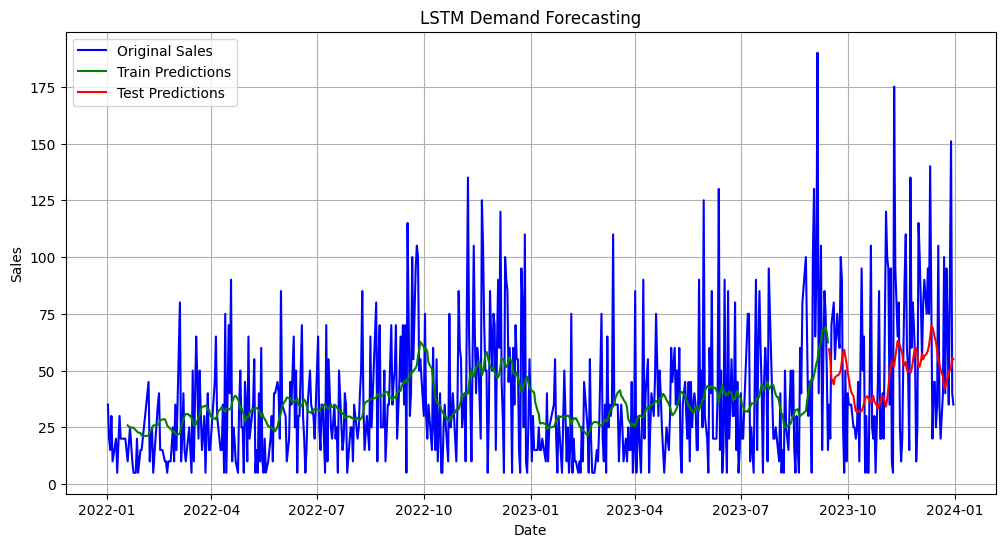

LSTM Evaluation Metrics:
RMSE: 37.2502965057428
MAE: 29.626771144866943
MAPE: 114.10%


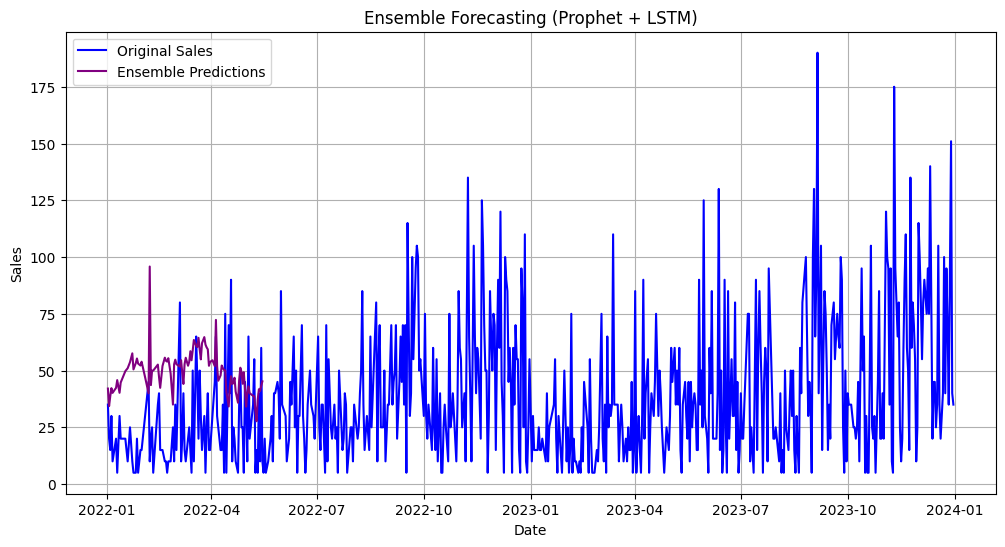

In [1]:
# Install necessary libraries for Colab
!pip install tensorflow pandas matplotlib sklearn prophet fbprophet pystan

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns
from prophet import Prophet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load the dataset
file_path = '/content/Car Sales.xlsx - car_data.csv'  # Adjust the file path in Colab
data = pd.read_csv(file_path)

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Feature Engineering
data['day_of_week'] = data['Date'].dt.dayofweek
data['month'] = data['Date'].dt.month
data['year'] = data['Date'].dt.year

# Aggregateing sales data by date
sales_by_date = data.groupby('Date').size().reset_index(name='Sales')

# --- Plotting  Car Sales Over Time ---
plt.figure(figsize=(12, 6))
plt.plot(sales_by_date['Date'], sales_by_date['Sales'], marker='o')
plt.title('Car Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Cars Sold')
plt.grid(True)
plt.show()

# --- Correlation Matrix of Numeric Features ---
numeric_features = data.select_dtypes(include=[np.number])
correlation_matrix = numeric_features.corr()

plt.figure(figsize=(10, 8))
plt.title('Correlation Matrix (Numeric Features)')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

# --- Car Sales Forecast Using Prophet ---
# Preparing the data for Prophet
prophet_data = sales_by_date.rename(columns={"Date": "ds", "Sales": "y"})

# Hyperparameter tuning for Prophet
prophet_model = Prophet(
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.05  # Allows more flexibility in trend changes
)

# Adding holidays (optional)
holidays = pd.DataFrame({
    'holiday': 'holiday_name',
    'ds': pd.to_datetime(['2024-12-25', '2024-01-01']),  # Example holiday dates
    'lower_window': 0,
    'upper_window': 1,
})
prophet_model.add_country_holidays(country_name='US')
prophet_model.fit(prophet_data)

# Create future dataframe and make forecast
future = prophet_model.make_future_dataframe(periods=30)  # Forecast 30 days into the future
forecast = prophet_model.predict(future)


# Plot the forecast
prophet_model.plot(forecast)
plt.title('Car Sales Forecast Using Prophet')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# --- Evaluation Metrics for Prophet ---
actual = sales_by_date['Sales'].values
predicted = forecast['yhat'][:len(actual)].values

# Compute evaluation metrics
rmse = np.sqrt(mean_squared_error(actual, predicted))
mae = mean_absolute_error(actual, predicted)
mape = np.mean(np.abs((actual - predicted) / actual)) * 100

print(f"Evaluation Metrics for Prophet:\nRMSE: {rmse}\nMAE: {mae}\nMAPE: {mape:.2f}%")

# --- LSTM Model Implementation ---
# Scale data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
sales_scaled = scaler.fit_transform(sales_by_date['Sales'].values.reshape(-1, 1))

# Prepare sequences for LSTM
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(x), np.array(y)

sequence_length = 10
x, y = create_sequences(sales_scaled, sequence_length)

# Split into training and testing sets using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.2),  # Dropout layer for regularization
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping and learning rate reduction for better performance
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Train the model
model.fit(x_train, y_train, batch_size=16, epochs=50, verbose=1, validation_data=(x_test, y_test),
          callbacks=[early_stopping, lr_scheduler])

# Make predictions
train_predictions = model.predict(x_train)
test_predictions = model.predict(x_test)

# Reverse scaling to original values
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(sales_by_date['Date'], sales_by_date['Sales'], label='Original Sales', color='blue')
plt.plot(sales_by_date['Date'][sequence_length:len(train_predictions)+sequence_length], train_predictions, label='Train Predictions', color='green')
plt.plot(sales_by_date['Date'][len(train_predictions)+sequence_length:], test_predictions, label='Test Predictions', color='red')
plt.title('LSTM Demand Forecasting')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# --- Evaluation Metrics for LSTM ---
lstm_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
lstm_mae = mean_absolute_error(y_test, test_predictions)
lstm_mape = np.mean(np.abs((y_test - test_predictions) / y_test)) * 100

print(f"LSTM Evaluation Metrics:\nRMSE: {lstm_rmse}\nMAE: {lstm_mae}\nMAPE: {lstm_mape:.2f}%")

# --- Combining Prophet and LSTM Predictions (Ensemble) ---
common_length = len(test_predictions)
ensemble_predictions = (forecast['yhat'][-common_length:].values + test_predictions.flatten()) / 2

# Plot ensemble predictions
plt.figure(figsize=(12, 6))
plt.plot(sales_by_date['Date'], sales_by_date['Sales'], label='Original Sales', color='blue')
plt.plot(sales_by_date['Date'][:len(ensemble_predictions)], ensemble_predictions, label='Ensemble Predictions', color='purple')
plt.title('Ensemble Forecasting (Prophet + LSTM)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

